# [7] Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from bs4 import BeautifulSoup
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import pickle

from tqdm import tqdm
import os
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [4]:

# using the SQLite Table to read data.
con = sqlite3.connect('D:/Machine Learning Notes/Python Notebook/Case Study/Amazon Fine Food Reviews Analysis/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 limit 10000""", con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [13]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
def clean_text(sentence):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower())
    return sentence.strip()
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [15]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

s=''
i=0
str1=' '
final_string=[]
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=clean_text(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1

#############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
             index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:29<00:00, 320.71it/s]


# LSTM

In [16]:
# split the data set into train and test
from sklearn import model_selection as ms
y=final['Score']
dw_train,dw_test,y_train,y_test=ms.train_test_split(final, y, test_size=0.2, random_state=0)
print(dw_train.shape,dw_test.shape)

(7651, 11) (1913, 11)


In [ ]:
#using keras.preprocessing.text.Tokenizer
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words= 3000)
tokenizer.fit_on_texts(dw_train['CleanedText'])
d_train = tokenizer.texts_to_sequences(dw_train['CleanedText'])
d_test = tokenizer.texts_to_sequences(dw_test['CleanedText'])

In [17]:
#Creating the Vocabulary
listAllWords=list()
for sent in tqdm(dw_train['CleanedText'].values):
    for w in sent.split():
        listAllWords.append(w)

100%|███████████████████████████████████████████████████████████████████████████| 7651/7651 [00:00<00:00, 39259.77it/s]


In [18]:
#creating dictionary of frequency of words
from collections import Counter
counts = Counter(listAllWords)

In [19]:
#top 2000 words
top2000_words = sorted(counts, key=counts.__getitem__)[-3000:]

In [23]:
top2000_words.index("the")

2999

In [76]:
#onehot encoding of training dataset using index
X_train=list()
for sent in tqdm(dw_train['CleanedText'].values):
    sen_vector=list()
    for w in sent.split():
        if (w in top2000_words): 
            sen_vector.append(top2000_words.index(w))
        else:
            sen_vector.append(0)
    X_train.append(sen_vector)

100%|██████████| 7651/7651 [00:38<00:00, 198.47it/s]


In [77]:
#onehot encoding of test dataset using index
X_test=list()
NoneType = type(None)
for sent in tqdm(dw_test['CleanedText'].values):
    sen_vector=list()
    for w in sent.split():
        if (w in top2000_words): 
            sen_vector.append(top2000_words.index(w))
        else:
            sen_vector.append(0)
    X_test.append(sen_vector)

100%|██████████| 1913/1913 [00:09<00:00, 204.47it/s]


In [0]:
#def plt_dynamic(x, vy, ty, fig, ax, colors=['b']):
    
def plotCurve(model,history):
  # list of epoch numbers
  x = list(range(1,epochs+1))
  vy = history.history['val_loss']
  ty = history.history['loss']
  #plt_dynamic(x, vy, ty, fig, ax)
  fig,ax = plt.subplots(1,1)
  ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
  ax.plot(x, vy, 'b', label="Validation Loss")
  ax.plot(x, ty, 'r', label="Train Loss")
  plt.legend()
  plt.grid()
  fig.canvas.draw()

In [0]:
def fitCalculate(d_trai ,d_tes, dropout, length):
    # truncate and/or pad input sequences
    max_review_length = 600
    d_trai = sequence.pad_sequences(d_trai, maxlen=max_review_length)
    d_tes = sequence.pad_sequences(d_tes, maxlen=max_review_length)
    # create the model
    embedding_vecor_length = 100
    model = Sequential()
    model.add(Embedding(length, embedding_vecor_length, input_length=max_review_length))
    model.add(LSTM(100))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    #Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model
    history = model.fit(d_trai, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(d_tes, y_test))
    score = model.evaluate(d_tes, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return model,history

In [0]:
batch_size = 64
epochs = 20
model,history = fitCalculate(d_train ,d_test, 0.75, 3000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 100)          300000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 380,501
Trainable params: 380,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 7651 samples, validate on 1913 samples
Epoch 1/20
7651/7651 [==============================] - 178s 23ms/step - loss: 0.4213 - acc: 0.8371 - val_loss: 0.3116 - val_acc: 0.8709
Epoch 2/20
7651/7651 [==============================] - 175s 23ms/step - loss:

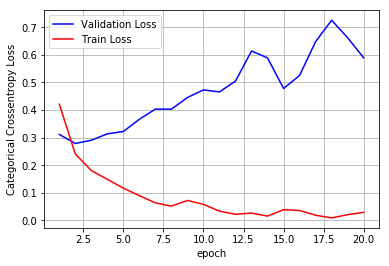

In [0]:
plotCurve(model,history)

In [0]:
batch_size = 64
epochs = 20
model1_2,history = fitCalculate(X_train ,X_test, 0.75, 3000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 100)          300000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 380,501
Trainable params: 380,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 7651 samples, validate on 1913 samples
Epoch 1/20
7651/7651 [==============================] - 179s 23ms/step - loss: 0.3969 - acc: 0.8442 - val_loss: 0.2761 - val_acc: 0.8787
Epoch 2/20
7651/7651 [==============================] - 175s 23ms/step - loss:

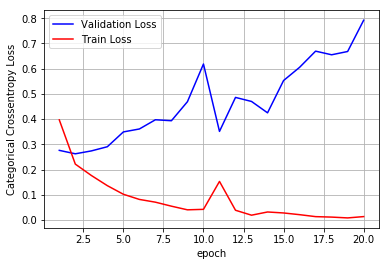

In [0]:
plotCurve(model1_2,history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 600, 100)          300000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 380,501
Trainable params: 380,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 7651 samples, validate on 1913 samples
Epoch 1/20
7651/7651 [==============================] - 178s 23ms/step - loss: 0.4049 - acc: 0.8434 - val_loss: 0.2985 - val_acc: 0.8845
Epoch 2/20
7651/7651 [==============================] - 175s 23ms/step - loss:

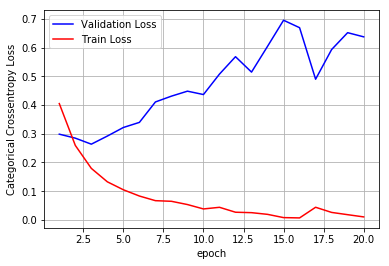

In [0]:
model1_3,history = fitCalculate(X_train ,X_test, 0.5, 3000)
plotCurve(model1_3,history)

## Model 2

In [0]:
def fitCalculate(d_trai ,d_tes, dropout, length):
    # truncate and/or pad input sequences
    max_review_length = 600
    d_trai = sequence.pad_sequences(d_trai, maxlen=max_review_length)
    d_tes = sequence.pad_sequences(d_tes, maxlen=max_review_length)
    # create the model
    embedding_vecor_length = 100
    model2 = Sequential()
    model2.add(Embedding(length, embedding_vecor_length, input_length=max_review_length))
    model2.add(LSTM(100, return_sequences=True))
    model2.add(Dropout(dropout))
    model2.add(LSTM(100))
    model2.add(Dropout(dropout))
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model2.summary())
    #Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model
    history = model2.fit(d_trai, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(d_tes, y_test))
    score = model2.evaluate(d_tes, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return model2,history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 600, 100)          300000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 600, 100)          80400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 600, 100)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 460,901
Trainable params: 460,901
Non-trainable params: 0
_________________________________________________________________
None

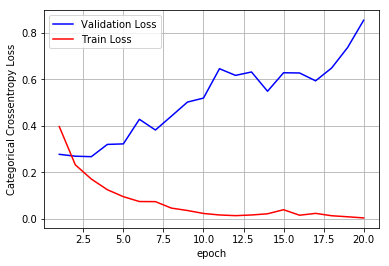

In [86]:
model2_1,history = fitCalculate(X_train ,X_test, 0.75, 3000)
plotCurve(model2_1,history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 600, 100)          300000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 600, 100)          80400     
_________________________________________________________________
dropout_16 (Dropout)         (None, 600, 100)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 460,901
Trainable params: 460,901
Non-trainable params: 0
_________________________________________________________________
None

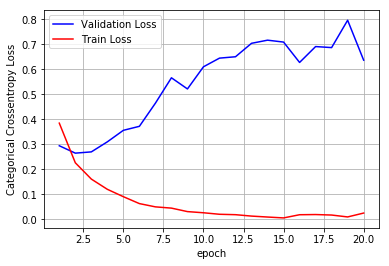

In [87]:
model2_2,history = fitCalculate(X_train ,X_test, 0.5, 3000)
plotCurve(model2_2,history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 600, 100)          300000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 600, 100)          80400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 600, 100)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 460,901
Trainable params: 460,901
Non-trainable params: 0
_________________________________________________________________
None

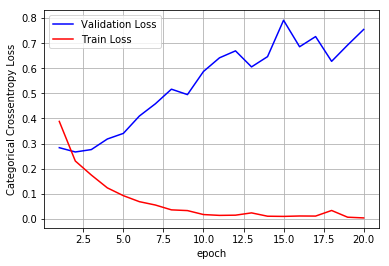

In [88]:
model2_3,history = fitCalculate(d_train ,d_test, 0.5, 3000)
plotCurve(model2_3,history)

# Conclusion

In [89]:
from prettytable import PrettyTable
    
pt = PrettyTable()

pt.field_names = ["Model", "Indexing","Number of LSTM Layer","Dropout"," Test Loss", "Test Accuracy"]

pt.add_row(["Model 1-1", "Tokenizer function",1, 0.75, 0.5896, 0.8708])
pt.add_row(["Model 1-2", "Counts of Words", 1, 0.75, 0.7920, 0.8792])
pt.add_row(["Model 1-3", "Counts of Words", 1, 0.50, 0.6372, 0.8776])
pt.add_row(["Model 2-1", "Counts of Words", 2, 0.75, 0.8538, 0.8907])
pt.add_row(["Model 2-2", "Counts of Words", 2, 0.50, 0.6363, 0.8766])
pt.add_row(["Model 2-3", "Tokenizer function",2, 0.50, 0.7547, 0.882])

print(pt)

+-----------+--------------------+----------------------+---------+------------+---------------+
|   Model   |      Indexing      | Number of LSTM Layer | Dropout |  Test Loss | Test Accuracy |
+-----------+--------------------+----------------------+---------+------------+---------------+
| Model 1-1 | Tokenizer function |          1           |   0.75  |   0.5896   |     0.8708    |
| Model 1-2 |  Counts of Words   |          1           |   0.75  |   0.792    |     0.8792    |
| Model 1-3 |  Counts of Words   |          1           |   0.5   |   0.6372   |     0.8776    |
| Model 2-1 |  Counts of Words   |          2           |   0.75  |   0.8538   |     0.8907    |
| Model 2-2 |  Counts of Words   |          2           |   0.5   |   0.6363   |     0.8766    |
| Model 2-3 | Tokenizer function |          2           |   0.5   |   0.7547   |     0.882     |
+-----------+--------------------+----------------------+---------+------------+---------------+


1) The model 1 has achieved an accuracy of 0.8997 and the test loss is 0.3912 .

2) The model has overfitted can be said looking at the train loss vs validation loss curve. The reason being less number of datapoints, which is one of the shortcoming of LSTM network. The model did great with 50K datapoints, but due to some reason the kernel kept collapsing after 10-11 epochs hence with 30k datapoints.

3) The stacking of LSTM layers can be done by simply making *return_sequences* parameter True.

4) The model with 2 LSTM-layers has certainly less test loss than that of model with 1 LSTM-layer.